In [ ]:
import sys
sys.path.append('../')  
sys.path.append('../src')  


# import os
# import sys

# script_directory = os.path.dirname(os.path.realpath(__file__))
# project_root = os.path.join(script_directory, '..')
# sys.path.append(project_root)


In [ ]:
import torch
import torch.nn as nn

import cv2
import matplotlib.pyplot as plt
dpt = cv2.imread(r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\validation_data_blender_DR\0000098depthB.png", cv2.IMREAD_UNCHANGED)
plt.imshow(dpt)
plt.figure()
dpt = cv2.imread(r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\validation_data_blender_DR\0000098depthA.png", cv2.IMREAD_UNCHANGED)
plt.imshow(dpt)



In [ ]:


class ruinDepth(nn.Module):
    def __init__(self):
        super().__init__()
        self.cn1 = nn.Conv2d(1, 3, kernel_size=(3,3), padding=1)
        self.rl1 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm2d(3)

        self.cn2 = nn.Conv2d(3, 7, kernel_size=(3,3), padding=1)
        self.rl2 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(7)

        self.cn3 = nn.Conv2d(7, 14, kernel_size=(3,3), padding=1)
        self.rl3 = nn.LeakyReLU()
        
        self.tcn1 = nn.ConvTranspose2d(14, 7, kernel_size=3, padding=1)
        self.rl4 = nn.Tanh()
        self.bn4 = nn.BatchNorm2d(7)
        self.bn4_2 = nn.BatchNorm2d(7)

        self.tcn2 = nn.ConvTranspose2d(7, 3, kernel_size=3, stride=4, output_padding=1, padding=1)
        self.rl5 = nn.Tanh()

        self.tcn3 = nn.ConvTranspose2d(3, 2, kernel_size=3)
        self.rl6 = nn.ReLU()

        self.mpool = nn.MaxPool2d(kernel_size=2)

                
    
    def forward(self, x):
        x = self.mpool(self.bn1(self.rl1(self.cn1(x))))
        x2 = self.mpool(self.bn2(self.rl2(self.cn2(x))))
        x = (self.rl3(self.cn3(x2)))

        x = self.bn4(self.bn4_2(self.rl4(self.tcn1(x))) + x2)
        self.x = x
        x = (self.rl5(self.tcn2(x))) 
        out = self.rl6(self.tcn3(x))
        return out


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import glob
import os
import numpy as np
from src.processDepth import depthCompletion

class SimDataset(Dataset):
    def __init__(self):
        root = r'C:\Users\dhruv\Desktop\680Final\data\0050'
        self.depthFiles =  sorted(glob.glob(os.path.join(root, 'depth/*.png')))
        self.depthFillFiles = sorted(glob.glob(os.path.join(root, 'depth/*.png')))

        self.depthtransform = depthCompletion(15, None, None, None, None)
    
    def __len__(self):
        return len(self.depthFiles)
    
    def __getitem__(self, idx):        
        img = np.float64(cv2.imread(self.depthFillFiles[idx], cv2.IMREAD_UNCHANGED))
        goodDepth = self.depthtransform.fillDepth(img)
        dp = transforms.ToTensor()(goodDepth)/1e3
        tar = transforms.ToTensor()(img)/1e3
        tar[tar>0.01] = 1
        tar[tar<=0.01] = 0
        return [dp, tar]


In [ ]:
from typing import Any
import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import CyclicLR
import torchvision
from torchvision import utils


class train(pl.LightningModule):
    def __init__(self):
        super().__init__()
        loader = SimDataset()
        self.train_loader = torch.utils.data.DataLoader(loader, shuffle=True, batch_size=32)
        self.network = ruinDepth()
        # self.tLoss = nn.MSELoss()
        self.CELoss = nn.CrossEntropyLoss(weight=torch.Tensor([0.6,0.4]))

        self.loss = 0
        self.itr = 0

    def training_step(self, batch, batch_idx):
        images, targets = batch
        pred = self.network.forward(images.float())        
        # mask = targets==0
        # loss =  0.5*self.tLoss(pred, targets.float()) + self.tLoss(pred[mask], targets[mask].float()) 
        loss = self.CELoss(pred, targets[:,0,:,:].long())

        if batch_idx==0:
            pred = torch.argmax(pred, dim=1)
            if self.current_epoch%10==0:
                imgs = [i.unsqueeze(0).cpu().detach() for i in self.network.x[0]]
                grid_img = utils.make_grid(imgs)  
                self.logger.experiment.add_image('Inference/Skip Layer', grid_img, self.current_epoch)
                self.logger.experiment.add_image('Inference/Input', images[0], self.current_epoch)
                self.logger.experiment.add_image('Inference/Output', pred[0].unsqueeze(0), self.current_epoch)
                self.logger.experiment.add_image('Inference/Target', targets[0], self.current_epoch)


        self.loss+=loss; self.itr+=len(images)
        return {'loss': loss}
            
    def train_dataloader(self):
        return self.train_loader
    
    def on_train_batch_end(self, outputs: STEP_OUTPUT, batch: Any, batch_idx: int) -> None:
        self.log("loss", self.loss/self.itr)
        self.loss = 0
        self.itr = 0
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

# TensorBoard Logger
logger = pl.loggers.TensorBoardLogger('../logs/tb_logs', name='depthruiner')

# Checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor='epoch',
    dirpath='checkpoints/',
    filename='my_model-{epoch:02d}-{loss:.2f}',
    save_top_k=3,
    mode='max',
)

# Learning Rate Monitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')

torch.set_float32_matmul_precision('medium')
model = train()

# Trainer with logger, checkpoint, and LR monitor
trainer = pl.Trainer(
    devices=1, 
    accelerator="gpu", 
    max_epochs=100, 
    logger=logger,
    callbacks=[checkpoint_callback, lr_monitor]
)


In [ ]:
torch.cuda.empty_cache()
# trainer = pl.Trainer(
#     devices=1, 
#     accelerator="gpu", 
#     max_epochs=100, 
#     logger=logger,
#     callbacks=[checkpoint_callback, lr_monitor]
# )

model = model.load_from_checkpoint(r'C:\Users\dhruv\Desktop\680Final\notebooks\checkpoints\my_model-epoch=41-loss=0.01.ckpt')
# trainer.fit(model)

In [ ]:
# def plotimg(img):
#     plt.figure(); plt.imshow(img);plt.show()
    

# train_loader = torch.utils.data.DataLoader(SimDataset(), shuffle=False, batch_size=1)
# model.network.eval()
# for img, tar in train_loader:
#     synth = img[0][0].cpu().detach().numpy(); plotimg(synth)
#     target = tar[0][0].cpu().detach().numpy(); plotimg(target)
#     pred = model.network.forward(img.cuda()); pred = torch.argmax(pred, dim=1); pred = pred[0].cpu().detach().numpy()
#     plotimg(pred)
#     break


In [ ]:
class depthCompletion2:
    """
    Unsuperivsed Depth completion
    Reference: 
        J. Ku, et al., "In Defense of Classical Image Processing: Fast Depth Completion on the CPU," 2018.
    """    
    def __init__(self, maxDepth, custom_kernel, full_5, full_7, full_31):
        self.max_depth = maxDepth
        if custom_kernel is None:
            #Replace this garbage with a function later
            custom_kernel = np.asarray([[0, 0, 0, 1, 0, 0, 0],
                                        [0, 0, 1, 1, 1, 0, 0],
                                        [0, 1, 1, 1, 1, 1, 0],
                                        [1, 1, 1, 1, 1, 1, 1],
                                        [0, 1, 1, 1, 1, 1, 0],
                                        [0, 0, 1, 1, 1, 0, 0],
                                        [0, 0, 0, 1, 0, 0, 0],], dtype=np.uint8)

        if full_5 is None:
            full_5 = np.ones((5, 5), np.uint8)
        if full_7 is None:
            full_7 = np.ones((7, 7), np.uint8)
        if full_31 is None:
            full_31 = np.ones((31, 31), np.uint8)

        self.custom_kernel = custom_kernel
        self.full_kernel_5 = full_5
        self.full_kernel_7 = full_7
        self.full_kernel_31 = full_31

    def fillDepth(self,inputImage):
        #Convert the mm to meters to be consistent with the paper
        img = np.float32(inputImage.copy())/1e3

        self.max_depth = img.max()*1.2
        #Threshold to maxDepth
        # img[img>self.max_depth] = self.max_depth

        #Valid image mask - 10 cm away
        valid_depth_mask = img>1e-3

        #1. Invert the Depth
        img[valid_depth_mask] = self.max_depth - img[valid_depth_mask]

        #2. Custom Kernel - ruins performance on inference :)
        # img = cv2.dilate(img, self.custom_kernel)

        #3. Small Hole Closure
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, self.full_kernel_5)
        
        #4. Small Hole Fill
        invalid_mask = img<1e-3 #Remember depth is not changed in inversion
        img[invalid_mask] = cv2.dilate(img, self.full_kernel_7)[invalid_mask]        
        
        #5. Large Hole Fill (authors loose patience at this step tbh)
        invalid_mask = img<1e-3
        img[invalid_mask] = cv2.dilate(img, self.full_kernel_31)[invalid_mask]

        # #6. Median+Bilateral
        img = cv2.medianBlur(img, 5)
        img = cv2.bilateralFilter(img, 5, 1.5, 2.0) #Slow but better

        #8 Depth correction
        valid_depth_mask = img>1e-3
        img[valid_depth_mask] = self.max_depth - img[valid_depth_mask]

        return img*1e3


In [ ]:
# dpt = cv2.imread(r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\validation_data_blender_DR\0000098depthB.png", cv2.IMREAD_UNCHANGED)
# dpt = np.float64(dpt)
# dpt = transforms.ToTensor()(dpt)/1e3
# model.network.eval()
# with torch.no_grad():
#     pred_ = torch.argmax(model.network.forward(dpt.float().cuda().unsqueeze(0)),dim=1)[0].cpu().detach().numpy()
# # plotimg(pred_)
# # pred_ = pred.copy()
# dp = depthCompletion2(15, None, np.ones((3,3)), np.ones((2,6)), np.ones((1,1))).fillDepth(pred_)
# mask = dp==0



# # img2 = img.clone()[0][0]
# img2 = dpt.clone()[0]
# img2[mask] = img2.min()
# plotimg(img2)
# print(img2.max())

In [ ]:
# # model.network.eval()
# # with torch.no_grad():
# #     pred_ = torch.argmax(model.network.forward(dpt.float().cuda().unsqueeze(0)),dim=1)[0].cpu().detach().numpy()
# # # plotimg(pred_)
# # # pred_ = pred.copy()
# # dp = depthCompletion2(15, None, np.ones((3,3)), np.ones((2,6)), np.ones((1,1))).fillDepth(pred_)
# # mask = dp==0

# from celluloid import Camera
# fig, axs = plt.subplots(1, 2)
# camera = Camera(fig)

# root = r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\validation_data_blender_DR"
# depthFiles =  sorted(glob.glob(os.path.join(root, '*depthB.png')))[:30]
# model.network.eval()
# # train_loader = torch.utils.data.DataLoader(SimDataset(), shuffle=False, batch_size=1)
# # model.network.eval()
# # for img, tar in train_loader:
# for i in depthFiles:
#     dpt = cv2.imread(i, cv2.IMREAD_UNCHANGED)
#     dpt = np.float64(dpt)
#     dpt = transforms.ToTensor()(dpt)/1e3
#     synth = dpt[0].cpu().detach().numpy().copy()
#     # target = tar[0][0].cpu().detach().numpy();# plotimg(target)
#     with torch.no_grad():
#         pred_ = torch.argmax(model.network.forward(dpt.cuda().unsqueeze(0).float()),dim=1)[0].cpu().detach().numpy()
#     dp = depthCompletion2(5, None, np.ones((3,3)), np.ones((2,6)), np.ones((5,5))).fillDepth(pred_)
#     mask = dp==0
#     synth[mask] = synth.min()
#     print(synth.min(),synth.max())
#     axs[0].imshow(dpt[0].cpu().detach().numpy() * 1e3, cmap='gray')
#     axs[0].axis('off')
#     axs[0].set_title('Raw Image')

#     axs[1].imshow(synth * 1e3, cmap='gray')
#     axs[1].axis('off')
#     axs[1].set_title('Predicted Image')

#     # plt.show()
#     camera.snap()
# animation = camera.animate()
# animation.save('animation.mp4', fps=1)








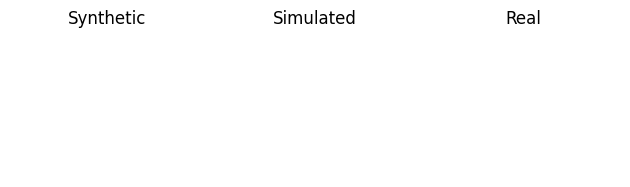

In [15]:
# model.network.eval()
# with torch.no_grad():
#     pred_ = torch.argmax(model.network.forward(dpt.float().cuda().unsqueeze(0)),dim=1)[0].cpu().detach().numpy()
# # plotimg(pred_)
# # pred_ = pred.copy()
# dp = depthCompletion2(15, None, np.ones((3,3)), np.ones((2,6)), np.ones((1,1))).fillDepth(pred_)
# mask = dp==0

from celluloid import Camera
fig, axs = plt.subplots(1, 3)
camera = Camera(fig)

root = r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\validation_data_blender_DR"
depthFiles =  sorted(glob.glob(os.path.join(root, '*depthB.png')))[:30]
model.network.eval()
train_loader = torch.utils.data.DataLoader(SimDataset(), shuffle=False, batch_size=1)
from tqdm import tqdm


sz = (640*1,480*1)

import psutil

def print_memory_usage():
    # Get memory information
    memory_info = psutil.virtual_memory()

    # Print memory information
    print(f"Total Memory: {memory_info.total} bytes")
    print(f"Available Memory: {memory_info.available} bytes")
    print(f"Used Memory: {memory_info.used} bytes")
    print(f"Memory Percent: {memory_info.percent}%")



i = 0
for img, tar in tqdm(train_loader):
    synth = img[0][0].cpu().detach().numpy().copy()
    target = tar[0][0].cpu().detach().numpy();# plotimg(target)
    with torch.no_grad():
        pred_ = torch.argmax(model.network.forward(img.cuda().float()),dim=1)[0].cpu().detach().numpy()
    dp = depthCompletion2(2, None, np.ones((3,3)), np.ones((2,6)), np.ones((1,1))).fillDepth(pred_)
    mask = dp==0
    axs[0].imshow(cv2.resize(synth, dsize=sz)  )
    axs[0].axis('off')
    axs[0].set_title('Synthetic')

    synth[mask] = 0
    

    axs[1].imshow(cv2.resize(synth * 1e3, dsize=sz))
    axs[1].axis('off')
    axs[1].set_title('Simulated')
    synth = img[0][0].cpu().detach().numpy().copy()
    mask = target==0
    synth[mask] = 0
    axs[2].imshow(cv2.resize(synth, dsize=sz))
    axs[2].axis('off')
    axs[2].set_title('Real')
    plt.tight_layout()


    # plt.show()
    i+=1
    camera.snap()
    if i%10==0:
        print_memory_usage()
animation = camera.animate()
animation.save('animation.mp4', fps=60, dpi=400)

In [16]:
del animation
del camera
plt.close()

In [ ]:

from celluloid import Camera
import matplotlib.pyplot as plt
import cv2; import glob; import os
fig, axs = plt.subplots(1, 2)
camera = Camera(fig)

root = r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\validation_data_blender_DR"
depthFiles =  sorted(glob.glob(os.path.join(root, '*depthB.png')))[:30]
rgbFiles =  sorted(glob.glob(os.path.join(root, '*rgbB.png')))[:30]

for i,j in zip(depthFiles, rgbFiles):
    dpt = cv2.imread(i, cv2.IMREAD_UNCHANGED)
    # dpt = np.float64(dpt)
    # dp = depthCompletion2(5, None, np.ones((3,3)), np.ones((2,6)), np.ones((1,1))).fillDepth(pred_)    
    axs[0].imshow(dpt, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Depth')
    synth = cv2.imread(j, cv2.IMREAD_COLOR)

    axs[1].imshow(synth)
    axs[1].axis('off')
    axs[1].set_title('RGB')

    # plt.show()
    camera.snap()
animation = camera.animate()
animation.save('dataset.mp4', fps=1)








In [ ]:
# model.network.eval()
# with torch.no_grad():
#     pred_ = torch.argmax(model.network.forward(dpt.float().cuda().unsqueeze(0)),dim=1)[0].cpu().detach().numpy()
# # plotimg(pred_)
# # pred_ = pred.copy()
# dp = depthCompletion2(15, None, np.ones((3,3)), np.ones((2,6)), np.ones((1,1))).fillDepth(pred_)
# mask = dp==0
import glob, os, tqdm

root = r"C:\Users\dhruv\Desktop\680Final\data\mustard_bottle\train_data_blender_DR"
depthFiles =  sorted(glob.glob(os.path.join(root, '*depthB.png')))
model.network.eval()
for i in tqdm.tqdm(depthFiles):
    dpt = cv2.imread(i, cv2.IMREAD_UNCHANGED)
    dpt = np.float64(dpt)
    dpt = transforms.ToTensor()(dpt)/1e3
    synth = dpt[0].cpu().detach().numpy().copy()
    with torch.no_grad():
        pred_ = torch.argmax(model.network.forward(dpt.cuda().unsqueeze(0).float()),dim=1)[0].cpu().detach().numpy()
    dp = depthCompletion2(5, None, np.ones((3,3)), np.ones((2,6)), np.ones((5,5))).fillDepth(pred_)
    mask = dp==0
    synth[mask] = 0
    synth = synth * 1e3
    synth = synth.astype(np.uint16)
    file = i.split(".png")[0]+"_fake.png"
    cv2.imwrite( file, synth)









In [ ]:
d1 = np.float64(cv2.imread(i, cv2.IMREAD_UNCHANGED))
d2 = np.float64(cv2.imread(file, cv2.IMREAD_UNCHANGED))
print(d1.min())
plt.imshow(d1)
plt.figure()
d2[d2==0] = 625
plt.imshow(d2)
print(file)
# plt.imshow(d2!=d1)